# Projet Machine Learning - Pump it Up Data Mining the Water Table

Using data from Taarifa and the Tanzanian Ministry of Water, the goal is to predict which pumps are functional, which need some repairs, and which are not functionnal at all.
Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

## I - Packages and input data

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import time
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

from codes.map_design import displayMap
from codes.predicteurs import Predict
from codes.unbalanced_predictions import unbalancedPrediction
from codes.getExtraData import regions_list, url_regions, get_label_climat_region

/Users/louisgiron/Desktop/ENSAE - Mastère spé/Machine Learning/projet_ml/codes/map_design.py:11: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('TkAgg')


In [2]:
path = os.getcwd()

# Import des données
train_set = pd.read_csv(path + '/data/training_set_values.csv', sep=',')
test_set = pd.read_csv(path + '/data/test_set_values.csv', sep=',')
train_labels = pd.read_csv(path + '/data/training_set_labels.csv', sep=',')

In [3]:
# Check the size of datasets
print('Train set shape:', train_set.shape)
print('Test set shape:', test_set.shape)
print('Train labels shape:', train_labels.shape)

Train set shape: (59400, 40)
Test set shape: (14850, 40)
Train labels shape: (59400, 2)


## II - Display the pump repartition on the Tanzanian map

(Using the class displayMap)

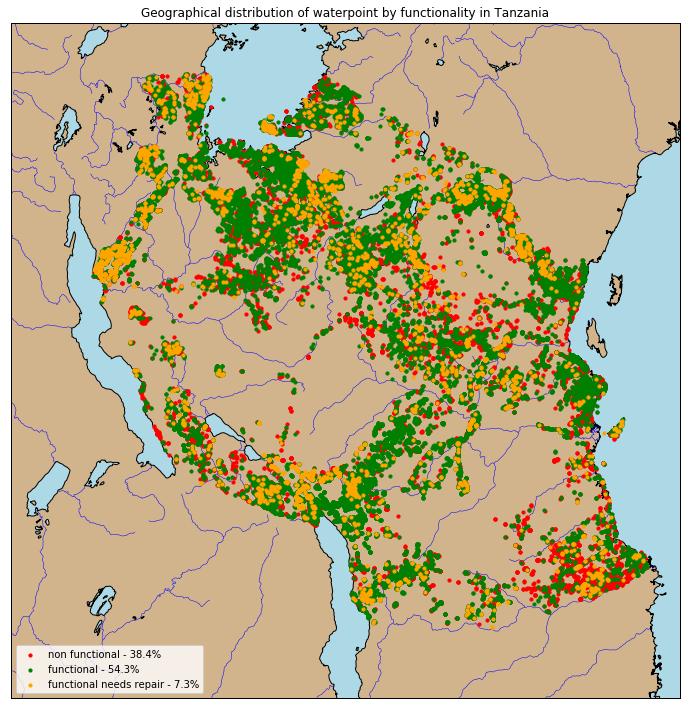

In [4]:
# Display the map
data = pd.merge(train_set, train_labels, how='inner')
map_water_pumps = displayMap(data, 'status_group')
map_water_pumps.display_map()
plt.show()

## III - Scrapp extra data

(from climate-data.org)

In [5]:
climat_infos_region = get_label_climat_region(regions_list, url_regions)

In [6]:
climat_infos_region.head()

,region,label_climat_reg
0,arusha,Csb
1,dar es salaam,Aw
2,dodoma,BSh
3,geita,Aw
4,iringa,Csb


In [7]:
# Merge the data
# train set
train_set['region'] = train_set['region'].apply(lambda x: x.lower())
# infos regions
train_set = train_set.merge(climat_infos_region, on='region', how='left')

# test set
test_set['region'] = test_set['region'].apply(lambda x: x.lower())
test_set = test_set.merge(climat_infos_region, on='region', how='left')

## IV - Exploratory Data Analysis 

Functionnal:  54.31
Non-Functionnal:  38.42
Functional needs repair:  7.27


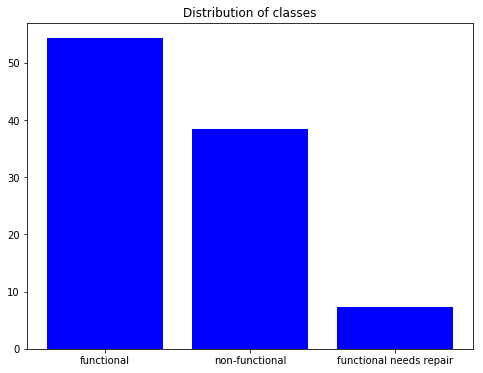

In [8]:
# Distribution of classes
legend = ['functional', 'non-functional', 'functional needs repair']
x = np.arange(len(train_labels['status_group'].unique()))
distrib = [round(train_labels[train_labels['status_group'] == x]['status_group'].count()/len(train_labels)*100,2)
           for x in train_labels['status_group'].unique()]

# List of distribution 
print('Functionnal: ', distrib[0])
print('Non-Functionnal: ', distrib[1])
print('Functional needs repair: ', distrib[2])

# Plot dsitribution as barplot
plt.figure(figsize=(8, 6))
plt.bar(x, distrib, color = 'blue')
plt.xticks(x, legend)
plt.title('Distribution of classes')
plt.show()

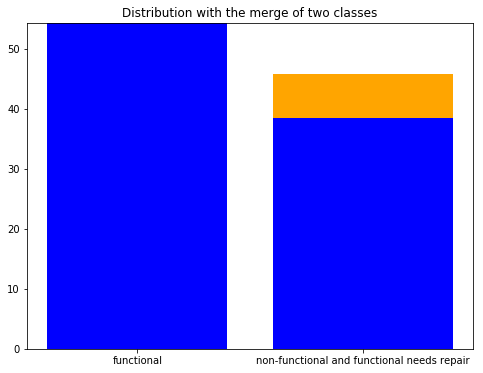

In [9]:
# Merge both under-represented classes
N = np.arange(2)
legend = ['functional', 'non-functional and functional needs repair']

distrib_1 = [round(train_labels[train_labels['status_group'] == x]['status_group'].count()/len(train_labels)*100,2)
             for x in ['functional', 'non functional']]
distrib_2 = [0, round(train_labels[train_labels['status_group'] == 'functional needs repair']['status_group'].count()/len(train_labels)*100,2)]

# Plot new distrib
plt.figure(figsize=(8, 6))
plt.bar(N, distrib_1, color = 'blue')
plt.bar(N, distrib_2, color = 'orange', bottom = distrib_1)
plt.xticks(N, legend)
plt.title('Distribution with the merge of two classes')
plt.show()

### A - Missing values study

In [10]:
# Features with missing data
missing = train_set.apply(lambda x: x.isnull().sum(), axis = 0)
missing = pd.DataFrame(missing)
missing.columns = ["Number of missing values"]


# Keep only features with missing data
missing = missing[missing['Number of missing values'] != 0]
missing['Share'] = round(missing['Number of missing values']/np.sum(missing['Number of missing values'])*100,2)
missing = missing.sort_values(by=['Share'], ascending=False)
print(missing)
print(missing.index)

                   Number of missing values  Share
scheme_name                           28166  61.11
scheme_management                      3877   8.41
installer                              3655   7.93
funder                                 3635   7.89
public_meeting                         3334   7.23
permit                                 3056   6.63
subvillage                              371   0.80
Index(['scheme_name', 'scheme_management', 'installer', 'funder',
       'public_meeting', 'permit', 'subvillage'],
      dtype='object')


In [11]:
list_missing = list(missing.index)
list_missing

['scheme_name',
 'scheme_management',
 'installer',
 'funder',
 'public_meeting',
 'permit',
 'subvillage']

scheme_name


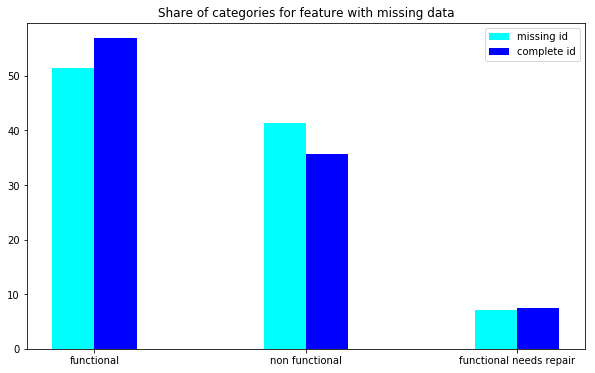

scheme_management


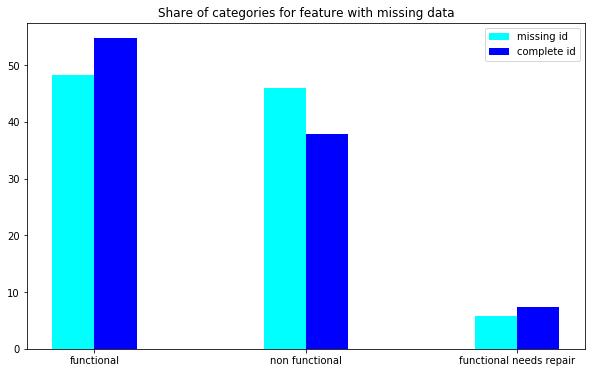

installer


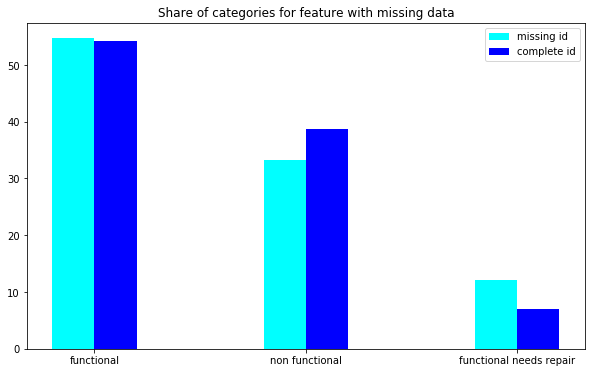

funder


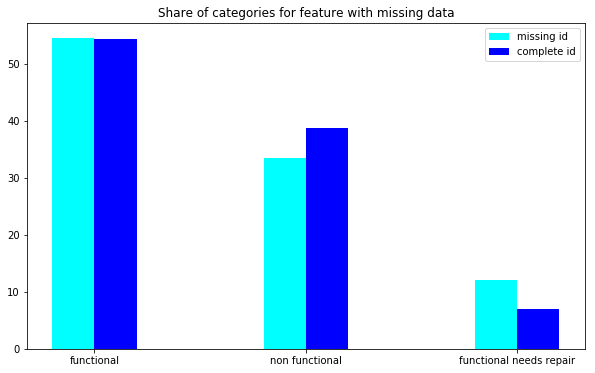

public_meeting


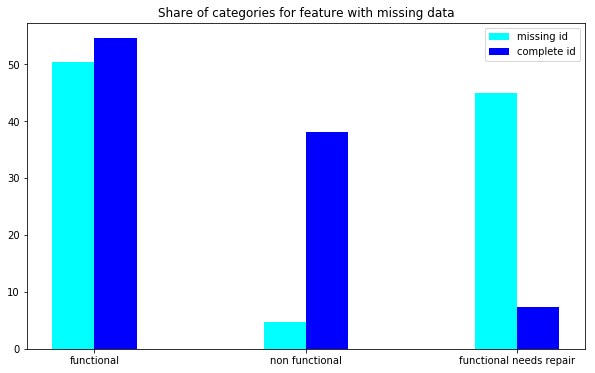

permit


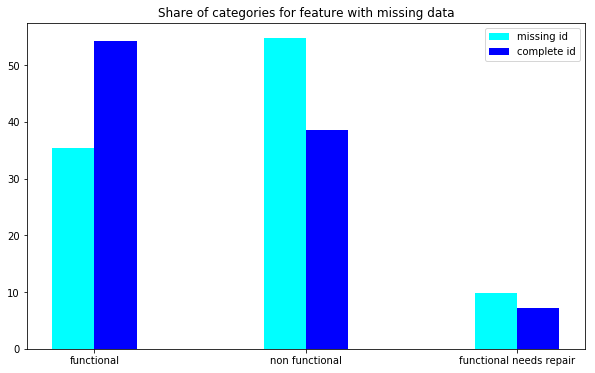

subvillage


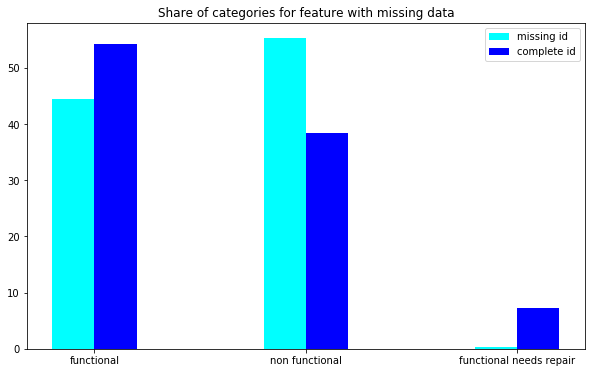

In [12]:
# Plot distribution by feature which belongs to 'list_missing'
train = pd.merge(train_set, train_labels, how='inner')
x = train['status_group'].unique()
legend = ['missing id', 'complete id']
N = np.arange(1, 4)
ecart = 0.1
N_1 = N - ecart
N_2 = N + ecart
for features in list_missing:
    isolate_1 = train[train[features].isnull() == True]
    isolate_2 = train[train[features].isnull() == False]
    count_1 = len(isolate_1)
    count_2 = len(isolate_2)
    share_1 = [round((isolate_1[isolate_1['status_group'] == x]['id'].count()/count_1)*100,2) for x in isolate_1['status_group'].unique()]
    share_2 = [round((isolate_2[isolate_2['status_group'] == x]['id'].count()/count_2)*100,2) for x in isolate_2['status_group'].unique()]
    plt.figure(figsize = (10,6))
    print(features)
    plt.bar(N_1, share_1,width= 0.2, color = 'cyan')
    plt.bar(N_2, share_2, width= 0.2, color = 'blue')
    plt.xticks(N, x)
    plt.title('Share of categories for feature with missing data')
    plt.legend(legend)
    plt.show()

Looking at shares of classes as percentage of missing values, we conclude missing vales might be relevant to detect pump with a status 'functional needs repair'.

### B - Categorical data study

In [13]:
train_set['density_population'] = train_set['population']/np.sum(train_set['population'])
test_set['density_population'] = test_set['population']/np.sum(test_set['population'])

# Which variable are categorical and which one are numerical
test_variable_float = np.float64(2)
test_variable_int = np.int64(1)

categorical = list()
numerical = list()

for x in train_set.columns:
    if (type(train_set[x].iloc[1]) == type(test_variable_float) or
       type(train_set[x].iloc[1]) == type(test_variable_int)):
        numerical.append(x)
    else:
        categorical.append(x)

print('Categorical variables:', len(categorical))
print(categorical)
print()
print('Numerical variables:', len(numerical))
print(numerical)

Categorical variables: 31
['date_recorded', 'funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'label_climat_reg']

Numerical variables: 11
['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'density_population']


In [14]:
# How many categorical ?
print('Number of categorical variables:', len(categorical))
# How many numerical ?
print('Number of numerical variables:', len(numerical))

Number of categorical variables: 31
Number of numerical variables: 11


#### Merge the train and test set so as to have the same treatment

In [15]:
train_set_index = train_set.index
test_set_index = test_set.index
data = pd.concat([train_set, test_set])

In [16]:
data_categ = data[categorical]
data_categ.head()

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,label_climat_reg
0,2011-03-14,Roman,Roman,none,Lake Nyasa,Mnyusi B,iringa,Ludewa,Mundindi,True,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,Csb
1,2013-03-06,Grumeti,GRUMETI,Zahanati,Lake Victoria,Nyamara,mara,Serengeti,Natta,NaN,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,Aw
2,2013-02-25,Lottery Club,World vision,Kwa Mahundi,Pangani,Majengo,manyara,Simanjiro,Ngorika,True,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,Csb
3,2013-01-28,Unicef,UNICEF,Zahanati Ya Nanyumbu,Ruvuma / Southern Coast,Mahakamani,mtwara,Nanyumbu,Nanyumbu,True,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,Aw
4,2011-07-13,Action In A,Artisan,Shuleni,Lake Victoria,Kyanyamisa,kagera,Karagwe,Nyakasimbi,True,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,Aw


#### Study of the number of categories within each variables : threshold approach

Nb: date_recorded will be our reference to evaluate the repartition of the categories within each variable since there is no missing values.

In [17]:
# Apply this method for all categorical variables
j = 1
for categ in categorical:
    if categ != 'date_recorded':
        temp = data_categ[[categ, 'date_recorded']]
        cat_var = temp.groupby([categ], as_index=False)['date_recorded'].count()

        cat_var.columns = [categ, 'count']
        cat_var['repartition_percent'] = cat_var['count']/np.sum(cat_var['count'])*100
        cat_var = cat_var.sort_values(by=['count'], ascending=False)
        cat_var.reset_index(inplace=True)
        
        # Visualize the 10 first (max) classes represented
        index_visualize = min(cat_var.shape[0], 10)
        cat_var_10_first = cat_var.loc[np.arange(0, index_visualize)]
        
        # Visualize the repartition taken the other classes as other
        var_retain = list(cat_var_10_first[categ])
        cat_var2 = cat_var[[categ, 'count']]
        cat_var2[categ] = cat_var2[categ].apply(lambda x: x if x in var_retain else 'other')
        cat_var2 = cat_var2.groupby([categ], as_index=False)['count'].sum()
        cat_var2['repartition_percent'] = cat_var2['count']/np.sum(cat_var2['count'])*100
        cat_var2 = cat_var2.sort_values(by=['count'], ascending=False)
    
        # Nb of different categories
        print('Categorical variable ' + str(j) + ':', categ)
        print('----')
        print('Number of categories initially:', cat_var.shape[0])
        print('\n---- 10 first categories represented')
        print(cat_var_10_first)
        print('\n---- Result if other assigned to all the other categories')
        print(cat_var2)
        print('')
        
        j += 1
        

/Users/louisgiron/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Categorical variable 1: funder
----
Number of categories initially: 2140

---- 10 first categories represented
   index                  funder  count  repartition_percent
0    507  Government Of Tanzania  11299            16.200212
1    293                  Danida   3907             5.601755
2    573                  Hesawa   2782             3.988759
3   1599                   Rwssp   1703             2.441717
4   2106              World Bank   1701             2.438850
5    808                    Kkkt   1623             2.327015
6   2108            World Vision   1562             2.239555
7   1961                  Unicef   1324             1.898317
8   1841                   Tasaf   1136             1.628767
9    327                     Dhv   1065             1.526969

---- Result if other assigned to all the other categories
                    funder  count  repartition_percent
10                   other  41644            59.708084
2   Government Of Tanzania  11299            16.2

Categorical variable 9: public_meeting
----
Number of categories initially: 2

---- 10 first categories represented
   index  public_meeting  count  repartition_percent
0      1            True  63749            90.946573
1      0           False   6346             9.053427

---- Result if other assigned to all the other categories
   public_meeting  count  repartition_percent
1            True  63749            90.946573
0           False   6346             9.053427

Categorical variable 10: recorded_by
----
Number of categories initially: 1

---- 10 first categories represented
   index              recorded_by  count  repartition_percent
0      0  GeoData Consultants Ltd  74250                100.0

---- Result if other assigned to all the other categories
               recorded_by  count  repartition_percent
0  GeoData Consultants Ltd  74250                100.0

Categorical variable 11: scheme_management
----
Number of categories initially: 12

---- 10 first categories represente

Categorical variable 18: management_group
----
Number of categories initially: 5

---- 10 first categories represented
   index management_group  count  repartition_percent
0      4       user-group  65538            88.266667
1      0       commercial   4591             6.183165
2      2       parastatal   2229             3.002020
3      1            other   1209             1.628283
4      3          unknown    683             0.919865

---- Result if other assigned to all the other categories
  management_group  count  repartition_percent
4       user-group  65538            88.266667
0       commercial   4591             6.183165
2       parastatal   2229             3.002020
1            other   1209             1.628283
3          unknown    683             0.919865

Categorical variable 19: payment
----
Number of categories initially: 7

---- 10 first categories represented
   index                payment  count  repartition_percent
0      0              never pay  31712       

Categorical variable 29: waterpoint_type_group
----
Number of categories initially: 6

---- 10 first categories represented
   index waterpoint_type_group  count  repartition_percent
0      1    communal standpipe  43239            58.234343
1      3             hand pump  21884            29.473401
2      5                 other   8010            10.787879
3      4       improved spring    959             1.291582
4      0         cattle trough    150             0.202020
5      2                   dam      8             0.010774

---- Result if other assigned to all the other categories
  waterpoint_type_group  count  repartition_percent
1    communal standpipe  43239            58.234343
3             hand pump  21884            29.473401
5                 other   8010            10.787879
4       improved spring    959             1.291582
0         cattle trough    150             0.202020
2                   dam      8             0.010774

Categorical variable 30: label_climat_r

### Missing values Analysis

cf previous part.

### Categorical Analysis

The previous study allows us to choose whether the categorical variable is relevant for our study or not. In fact, if the categorical variable shows a significant percentage of "other" category, we can state on the unrelevance of the aforementionned variable. Furthemore, if a categorical variable contains a huge amount of categories, we can also consider the variable as not relevant.

Moreover, some variables are contained in other variables such as:
- 'wpt_name' and 'subvillage' are contained in the variable 'longitude' and 'latitude'.
- extraction_type_group, extraction_type_class are contained in extraction_type
- etc ...

Finally, the variable 'recorded_by' contains only one category.

### Final choice

Therefore, we choose to keep for our study the following variables: ( var (nb_categories) )
- installer : Choice DWE and Other
- basin (9)
- region (21)
- public_meeting (2) : Missing values analysis shows this variable is discriminant. Creation of a                                        subcategory 'missing' which contains a lot of 'needs to repair' labels.
- scheme_management (12)
- permit (2) : Missing values analysis shows this variable is discriminant. Creation of a                                        subcategory 'missing'.
- extraction_type (18)
- management (12)
- payment (7)
- water_quality (8)
- quality_group (6) 
- quantity (5)
- source (10)
- waterpoint_type (7)
- label_climat_reg (3)


In [18]:
categorical_selected = ['installer', 'basin', 'region', 'public_meeting', 'scheme_management',
                        'permit', 'extraction_type', 'management', 'payment', 'water_quality',
                       'quality_group', 'quantity', 'source', 'waterpoint_type', 'label_climat_reg']

#### Management of the categorical variables which contains nan and/or relevant information

In [19]:
# installer
data['installer'] = data['installer'].apply(lambda x: x if x == 'DWE' else 'other')

# public_meeting
data['public_meeting'] = data['public_meeting'].fillna('missing')

# permit
data['permit'] = data['permit'].fillna('missing')

# scheme_management
data['scheme_management'] = data['scheme_management'].fillna('missing')

#### One Hot encoder for categorical variables

In [20]:
# select the proper dataset
data_selected = data[categorical_selected]
data_selected[numerical] = data[numerical]

# One hot encoder for categorical variables
data_selected = pd.get_dummies(data_selected)

/Users/louisgiron/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


#### Label encoder

In [21]:
# Label encoder
code = LabelEncoder()
code.fit(['functional', 'non functional', 'functional needs repair'])
train_labels['status_group_labels_encode'] = code.transform(train_labels['status_group'])

#### Merge the datasets and generate the training set

In [22]:
# Generate train et test set
train_set = data_selected.loc[train_set_index]
test_set = data_selected.loc[test_set_index]

In [23]:
# Merge the data
train = pd.merge(train_set, train_labels, how='inner')

In [24]:
print('Train set shape - encoded:', train.shape)
print('Test set shape - encoded:', test_set.shape)

Train set shape - encoded: (59400, 140)
Test set shape - encoded: (29700, 138)


### C - Feature importance

In [25]:
X = train.drop(['status_group', 'status_group_labels_encode'], axis=1).copy()
y = train['status_group_labels_encode'].copy()

In [26]:
print('Shape of X:', X.shape)
print('Shape of y:', y.shape)

Shape of X: (59400, 138)
Shape of y: (59400,)


In [27]:
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(np.array(X), np.array(y))
print('Feature importance coefficient:')
print(clf.feature_importances_)

Feature importance coefficient:
[8.73444765e-02 1.10773764e-02 4.80628080e-02 9.83679483e-02
 9.78133273e-02 1.37329121e-03 7.10253720e-03 1.64664405e-02
 2.99211236e-02 3.57643162e-02 2.96906330e-02 7.66366076e-03
 7.84551983e-03 3.81319277e-03 3.32434002e-03 2.99715491e-03
 3.77164249e-03 3.87448674e-03 3.26564218e-03 3.37506181e-03
 2.33431679e-03 3.34816626e-03 1.46072697e-03 5.36418903e-04
 1.37057450e-03 3.50203608e-03 1.98557903e-03 2.54068642e-03
 2.40885484e-03 1.20721390e-03 8.25726663e-04 1.97180747e-03
 2.04940605e-03 1.89712866e-03 1.66598269e-03 2.22619483e-03
 1.97745393e-03 1.53721891e-03 2.11471102e-03 3.20518309e-03
 9.77698116e-04 1.28665879e-03 1.77443796e-03 4.97220627e-03
 6.53232038e-03 2.87848038e-03 1.90659651e-03 3.62859502e-07
 8.48791855e-04 1.47619132e-03 1.09294495e-03 9.56875192e-05
 2.55008621e-04 6.88930060e-03 1.53121378e-03 3.05863274e-03
 3.02402909e-03 2.42700582e-03 2.92659175e-03 7.53730808e-03
 7.60171803e-03 2.69646972e-03 2.42086232e-03 1.81407

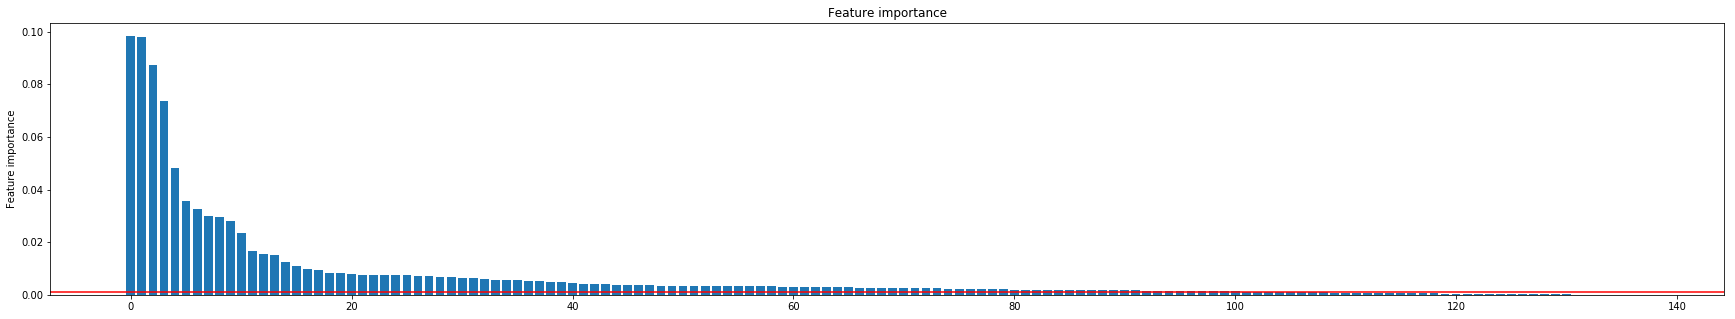

In [28]:
# Limitation for the feature importance
lim_feature_imp = 0.001
labels = X.columns

# Sorted
sort_features = np.argsort(clf.feature_importances_)[::-1]
feature_importance_sorted = clf.feature_importances_[sort_features]
labels_sorted = labels[sort_features]

# Figure
fig = plt.figure(figsize=(30, 5))
plt.bar(np.arange(0, len(clf.feature_importances_)), feature_importance_sorted)
plt.axhline(y=lim_feature_imp, color='r', linestyle='-')
plt.ylabel('Feature importance')
plt.title('Feature importance')
plt.show()

In [29]:
print('Selected labels:')
print(labels_sorted)
print()
print('Nb of labels:', len(labels_sorted))

Selected labels:
Index(['longitude', 'latitude', 'id', 'quantity_dry', 'gps_height',
       'construction_year', 'extraction_type_other', 'population',
       'density_population', 'quantity_enough',
       ...
       'extraction_type_other - play pump', 'extraction_type_walimi',
       'extraction_type_cemo', 'management_other - school',
       'scheme_management_SWC', 'extraction_type_climax',
       'water_quality_fluoride abandoned', 'waterpoint_type_dam',
       'extraction_type_other - mkulima/shinyanga', 'scheme_management_None'],
      dtype='object', length=138)

Nb of labels: 138


In [30]:
# Selection of the variable:
variables_selected = []
for i in range(len(feature_importance_sorted)):
    if feature_importance_sorted[i] > lim_feature_imp:
        variables_selected.append(labels_sorted[i])

print('Variables selected with the feature importance analysis:')
print(variables_selected)
print()
print('Nb of variables selected:', len(variables_selected))

Variables selected with the feature importance analysis:
['longitude', 'latitude', 'id', 'quantity_dry', 'gps_height', 'construction_year', 'extraction_type_other', 'population', 'density_population', 'quantity_enough', 'waterpoint_type_other', 'district_code', 'quantity_insufficient', 'payment_never pay', 'waterpoint_type_communal standpipe', 'amount_tsh', 'waterpoint_type_hand pump', 'waterpoint_type_communal standpipe multiple', 'source_spring', 'extraction_type_gravity', 'installer_other', 'payment_pay per bucket', 'installer_DWE', 'permit_True', 'management_vwc', 'permit_False', 'region_code', 'extraction_type_nira/tanira', 'scheme_management_VWC', 'payment_unknown', 'public_meeting_True', 'quantity_seasonal', 'payment_pay monthly', 'source_river', 'source_shallow well', 'label_climat_reg_Csb', 'source_machine dbh', 'label_climat_reg_Aw', 'public_meeting_False', 'quality_group_unknown', 'water_quality_unknown', 'source_rainwater harvesting', 'water_quality_soft', 'extraction_type_

## V - 1 - Predictions & Submissions - 3 classes problem

In [31]:
# Select the id to submit
submit = pd.read_csv(path + '/data/SubmissionFormat.csv', sep=',')
submit_id = submit['id']
X = pd.concat([train_set, test_set], sort=False)
X = X.drop_duplicates(subset='id')

# Define the dataset to submit
X_submit = X.loc[X['id'].isin(submit_id)]
X_learn = X.loc[~X['id'].isin(submit_id)]
X_learn = pd.merge(X_learn, train_labels, on='id', how='inner')

# Variable selection and definition of the train data
X = X_learn[variables_selected]
y = np.array(X_learn['status_group_labels_encode'])
submit = X_submit[variables_selected]

In [32]:
X.head()

,longitude,latitude,id,quantity_dry,gps_height,construction_year,extraction_type_other,population,density_population,quantity_enough,...,region_arusha,num_private,region_dodoma,payment_other,region_tabora,management_wua,region_lindi,management_water authority,management_other,scheme_management_Private operator
0,34.938093,-9.856322,69572,0,1390,1999,0,109,0.000010,1,...,0,0,0,0,0,0,0,0,0,0
1,34.698766,-2.147466,8776,0,1399,2010,0,280,0.000026,0,...,0,0,0,0,0,0,0,0,0,0
2,37.460664,-3.821329,34310,0,686,2009,0,250,0.000023,1,...,0,0,0,0,0,0,0,0,0,0
3,38.486161,-11.155298,67743,1,263,1986,0,58,0.000005,0,...,0,0,0,0,0,0,0,0,0,0
4,31.130847,-1.825359,19728,0,0,0,0,0,0.000000,0,...,0,0,0,0,0,0,0,0,1,0


In [33]:
submit.head()

,longitude,latitude,id,quantity_dry,gps_height,construction_year,extraction_type_other,population,density_population,quantity_enough,...,region_arusha,num_private,region_dodoma,payment_other,region_tabora,management_wua,region_lindi,management_water authority,management_other,scheme_management_Private operator
0,35.290799,-4.059696,50785,0,1996,2012,1,321,0.000117,0,...,0,0,0,0,0,0,0,0,0,0
1,36.656709,-3.309214,51630,0,1569,2000,0,300,0.000110,0,...,1,0,0,0,0,0,0,0,0,0
2,34.767863,-5.004344,17168,0,1567,2010,1,500,0.000183,0,...,0,0,0,0,0,0,0,0,0,0
3,38.058046,-9.418672,45559,1,267,1987,1,250,0.000091,0,...,0,0,0,0,0,0,1,0,0,0
4,35.006123,-10.950412,49871,0,1260,2000,0,60,0.000022,1,...,0,0,0,0,0,0,0,0,0,0


In [34]:
print('X shape:', X.shape)
print('Submit shape:', submit.shape)

X shape: (59400, 106)
Submit shape: (14850, 106)


### Predictions

In [35]:
# Predict
#sm = SMOTE(random_state=2)
#X_sm, y_sm = sm.fit_sample(X, y.ravel())
predicteur = Predict(X, y)

# time
start = time.time()

ArbreDecision_predictions = predicteur.make_prediction('ArbreDecision', submit)
XGBoost_predictions = predicteur.make_prediction('XgBoost', submit)
RandomForest_predictions = predicteur.make_prediction('RandomForest', submit)
GradientBoosting_predictions = predicteur.make_prediction('GradientBoosting', submit)

exec_time = np.round((time.time() - start)/60, 2)
print('Execution time:', exec_time, 'min')
print()

# Scores
print('Score Arbre de décision: ', ArbreDecision_predictions[1])
print('Score XGBoost: ', XGBoost_predictions[1])
print('Score GradientBoosting: ', GradientBoosting_predictions[1])
print('Score RandomForest: ', RandomForest_predictions[1])

Execution time: 39.21 min

Score Arbre de décision:  0.733292521171309
Score XGBoost:  0.7990001020304051
Score GradientBoosting:  0.7403326191204979
Score RandomForest:  0.7419140903989389


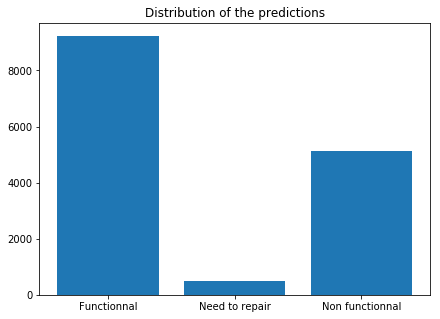

In [36]:
# Distribution of the predictions of the best predictor
pred = XGBoost_predictions[0]
pred = [np.sum(pred==0), np.sum(pred==1), np.sum(pred==2)]
labels = ['Functionnal', 'Need to repair', 'Non functionnal']
plt.figure(figsize=(7, 5))
plt.bar(np.arange(0, 3), pred)
plt.xticks(np.arange(0, 3), labels)
plt.title('Distribution of the predictions')
plt.show()

### Submissions

In [37]:
# Prediction of the dataset - Submit
path_submit = path + '/submissions'

# Best model
to_submit = pd.DataFrame()
to_submit['id'] = X_submit['id']
to_submit['status_group'] = code.inverse_transform(XGBoost_predictions[0])
# CSV
to_submit.to_csv(path_submit + '/Submissions_xgboost.csv', sep=",",
                 header=True, index=False)

## V - 2 - Predictions & Submissions - 2/2 classes problem

### Predictions

In [38]:
# Predict with the SMOTE method
# time
start = time.time()

# ArbreDecision
ArbreDecision = unbalancedPrediction(X, y, submit, 'ArbreDecision', variables_selected)
ArbreDecision_pred = ArbreDecision.processDataPredicted()

# XGBoost
XGBoost = unbalancedPrediction(X, y, submit, 'XgBoost', variables_selected)
XGBoost_pred = XGBoost.processDataPredicted()

# RandomForest
RandomForest = unbalancedPrediction(X, y, submit, 'RandomForest', variables_selected)
RandomForest_pred = RandomForest.processDataPredicted()

# GradientBoosting
GradientBoosting = unbalancedPrediction(X, y, submit, 'GradientBoosting', variables_selected)
GradientBoosting_pred = GradientBoosting.processDataPredicted()

exec_time = np.round((time.time() - start)/60, 2)
print('Execution time:', exec_time, 'min')
print()

# Score
print('Score Arbre de décision: ', ArbreDecision_pred[1])
print('Score XGBoost: ', XGBoost_pred[1])
print('Score GradientBoosting: ', GradientBoosting_pred[1])
print('Score RandomForest: ', RandomForest_pred[1])

/Users/louisgiron/Desktop/ENSAE - Mastère spé/Machine Learning/projet_ml/codes/unbalanced_predictions.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.x_data['labels'] = y_learn
/Users/louisgiron/Desktop/ENSAE - Mastère spé/Machine Learning/projet_ml/codes/unbalanced_predictions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.x_data['Class 1'] = self.x_data['labels'].apply(lambda x: 1 if
/Users/louisgiron/Desktop/ENSAE - Mastère spé/Machine Learning/projet_ml/codes/unbalanced_predictions.py:71: SettingWithCopyWarnin

Execution time: 60.77 min

Score Arbre de décision:  0.7403535353535353
Score XGBoost:  0.8684848484848485
Score GradientBoosting:  0.7614983164983165
Score RandomForest:  0.7612794612794613


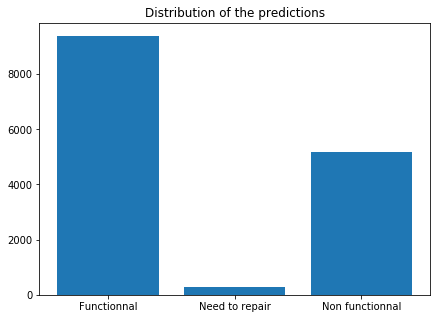

In [39]:
# Distribution of the predictions of the best predictor
pred = XGBoost_pred[0]
pred = [np.sum(pred==0), np.sum(pred==1), np.sum(pred==2)]
labels = ['Functionnal', 'Need to repair', 'Non functionnal']
plt.figure(figsize=(7, 5))
plt.bar(np.arange(0, 3), pred)
plt.xticks(np.arange(0, 3), labels)
plt.title('Distribution of the predictions')
plt.show()

### Submissions

In [40]:
# XGBoost
to_submit = pd.DataFrame()
to_submit['id'] = X_submit['id']
to_submit['status_group'] = code.inverse_transform(XGBoost_pred[0])
# CSV
to_submit.to_csv(path_submit + '/Submissions_xgboost_smote.csv', sep=",",
                 header=True, index=False)